In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=178a288762fce726adcd416002cfb4288e4f4d8371d4fe27f08909191b82f285
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.7 GB  |     Proc size: 118.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
import csv
import numpy as np
import random
import torch
from PIL import Image
from torch.utils.data import DataLoader,TensorDataset
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize, RandomAffine,RandomResizedCrop,CenterCrop
from torchvision.transforms import ToTensor, Normalize,transforms
from PIL.Image import BICUBIC

In [ ]:
from PIL.Image import BICUBIC
from PIL import Image
from torchvision.datasets.cifar import CIFAR100, CIFAR10
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize, RandomAffine
from torchvision.transforms import ToTensor, Normalize

from torch.utils.data import Subset,Dataset
import torchvision.utils as vutils
import random
from torch.utils.data import DataLoader
import numpy as np
import random

In [ ]:
from torch.utils.data import Subset,Dataset

In [ ]:
def load_cifar10(train_size=4000,train_rho=0.01,val_size=1000,val_rho=1,image_size=224,batch_size=128,num_workers=4,path='./data',num_classes=10):
    train_transform = Compose([
        RandomCrop(32,padding=4),
        Resize(image_size, BICUBIC),
        #RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.98, 1.02), shear=2, fillcolor=(124,117,104)),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

    test_transform = Compose([
        Resize(image_size, BICUBIC),    
        ToTensor(),
        Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

    train_dataset = CIFAR10(root=path, train=True, transform=train_transform, download=True)
    test_dataset = CIFAR10(root=path, train=False, transform=test_transform, download=True)
    train_x,train_y = np.array(train_dataset.data), np.array(train_dataset.targets)
    #test_x, test_y = test_dataset.data, test_dataset.targets
    num_train_samples=[]
    num_val_samples=[]
    pi = []
    train_mu=train_rho**(1./9.)
    val_mu=val_rho**(1./9.)
    for i in range(num_classes):
        num_train_samples.append(round(train_size*(train_mu**i)))
        num_val_samples.append(round(val_size*(val_mu**i)))
        pi.append(train_mu**i)
    train_index=[]
    val_index=[]
    #print(train_x,train_y)
    print(num_train_samples,num_val_samples)
    for i in range(num_classes):
        train_index.extend(np.where(train_y==i)[0][:num_train_samples[i]])
        val_index.extend(np.where(train_y==i)[0][-num_val_samples[i]:])
        #index.extend()
    random.shuffle(train_index)
    random.shuffle(val_index)
    
    train_data,train_targets=train_x[train_index],train_y[train_index]
    val_data,val_targets=train_x[val_index],train_y[val_index]
    
    train_dataset = CustomDataset(train_data,train_targets,train_transform)
    val_dataset = CustomDataset(val_data,val_targets,train_transform)
    train_eval_dataset = CustomDataset(train_data,train_targets,test_transform)
    val_eval_dataset = CustomDataset(val_data,val_targets,test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, 
                            shuffle=True, drop_last=False, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, 
                            shuffle=True, drop_last=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, 
                            shuffle=False, drop_last=False, pin_memory=True)

    eval_train_loader = DataLoader(train_eval_dataset, batch_size=batch_size, num_workers=num_workers, 
                                shuffle=False, drop_last=False, pin_memory=True)
    eval_val_loader = DataLoader(train_eval_dataset, batch_size=batch_size, num_workers=num_workers, 
                                shuffle=False, drop_last=False, pin_memory=True)

    return train_loader,val_loader,test_loader,eval_train_loader,eval_val_loader,num_train_samples,num_val_samples,pi

class CustomDataset(Dataset):
    """CustomDataset with support of transforms.
    """
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target
    def __len__(self):
        return len(self.data)
#load_cifar10()

In [ ]:
num_classes=10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1,BN=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        if BN:
            self.bn1 = nn.BatchNorm2d(planes)
            self.bn2 = nn.BatchNorm2d(planes)
        else:
            self.bn1 = nn.Sequential()
            self.bn2 = nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            if BN:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion*planes,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion*planes)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion * planes,
                              kernel_size=1, stride=stride, bias=False)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,in_planes=16,BN=True):
        super(ResNet, self).__init__()
        self.in_planes = in_planes
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        if BN:
            self.bn1 = nn.BatchNorm2d(in_planes)
        else:
            self.bn1 = nn.Sequential()
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1,BN=BN)
        self.layer2 = self._make_layer(block, in_planes*2, num_blocks[1], stride=2,BN=BN)
        self.layer3 = self._make_layer(block, in_planes*4, num_blocks[2], stride=2,BN=BN)
        self.avg_pool=nn.AvgPool2d(8)
        self.linear = nn.Linear(in_planes*4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride,BN):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,BN=BN))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out=self.avg_pool(out)
        feature = out.view(out.size(0), -1)
        logits = self.linear(feature)
        return logits

def ResNet20(num_classes=10,BN=True):
    num_res_blocks = int((20 - 2) / 6)
    return ResNet(BasicBlock, [num_res_blocks, num_res_blocks, num_res_blocks],num_classes=num_classes,BN=BN)
def test():
    net = ResNet20(BN=True)
    print(sum(p.numel() for p in net.parameters() if p.requires_grad))
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y)
    print(y[0].size(),y[1].size())

In [ ]:
batch_size = 64
ARCH_EPOCH = 120
lr = 0.1
arch_lr = 0.01 
train_rho = 0.01

In [ ]:
network_model ='ResNet20'
model=ResNet20(num_classes=num_classes)
train_loader,val_loader,test_loader,eval_train_loader,eval_val_loader,num_train_samples,num_val_samples,pi=load_cifar10(batch_size=batch_size,train_rho=train_rho,image_size=32)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[4000, 2398, 1438, 862, 517, 310, 186, 111, 67, 40] [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import math

In [ ]:
-np.log10(pi)

array([-0.        ,  0.22222222,  0.44444444,  0.66666667,  0.88888889,
        1.11111111,  1.33333333,  1.55555556,  1.77777778,  2.        ])

In [ ]:
np.square(np.log10(pi))

array([0.        , 0.04938272, 0.19753086, 0.44444444, 0.79012346,
       1.2345679 , 1.77777778, 2.41975309, 3.16049383, 4.        ])

In [ ]:
np.sqrt(-np.log10(pi))

array([-0.        ,  0.47140452,  0.66666667,  0.81649658,  0.94280904,
        1.05409255,  1.15470054,  1.24721913,  1.33333333,  1.41421356])

In [ ]:
np.ones([num_classes])/pi

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ])

In [ ]:
(np.ones([num_classes])/pi)**0.15

array([1.        , 1.07977516, 1.1659144 , 1.25892541, 1.35935639,
       1.46779927, 1.58489319, 1.7113283 , 1.8478498 , 1.99526231])

In [ ]:
(np.ones([num_classes])/pi)**0.3

array([1.        , 1.1659144 , 1.35935639, 1.58489319, 1.8478498 ,
       2.15443469, 2.51188643, 2.92864456, 3.41454887, 3.98107171])

In [ ]:
np.ones([num_classes])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
dic = []
dic.append(-np.log10(pi)/max(-np.log10(pi)))
dic.append(np.square(np.log10(pi))/max(np.square(np.log10(pi))))
dic.append(np.sqrt(-np.log10(pi))/max(np.sqrt(-np.log10(pi))))
dic.append((np.ones([num_classes])/pi)/max(np.ones([num_classes])/pi))
dic.append(np.sqrt(np.ones([num_classes])/pi)/max(np.sqrt(np.ones([num_classes])/pi)))
dic.append(((np.ones([num_classes])/pi)**0.3)/max((np.ones([num_classes])/pi)**0.3))
dic.append(((np.ones([num_classes])/pi)**2)/max((np.ones([num_classes])/pi)**2))
dic.append(np.ones([num_classes]))


In [ ]:
import matplotlib.pyplot as plt


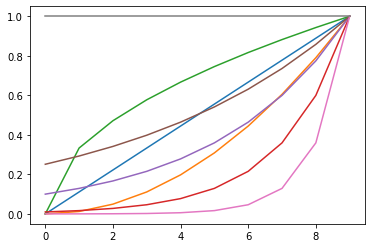

In [ ]:
for i in range(np.shape(dic)[0]):
  plt.plot(dic[i])

In [ ]:
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params 
    print("-" * 50)
    print("Total number of parameters: {:.2e}".format(total_num_params))

In [ ]:
!pip install ignite

In [ ]:

import os
import numpy as np
import random
from numpy.lib.scimath import log
import torch
import ignite
from torch._C import dtype

import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn

assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled
torch.backends.cudnn.benchmark = True
device = "cuda"

In [ ]:
print_num_params(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

--------------------------------------------------
Total number of parameters: 2.72e+05


In [ ]:
num_w = 8

In [ ]:
dy_w= torch.zeros([num_w],dtype=torch.float32,device=device)
ly_w= torch.zeros([num_w],dtype=torch.float32,device=device)
dy_w[-1] = 1
ly_w[0] = 1
ly_w=torch.tensor(ly_w).cuda()
dy_w=torch.tensor(dy_w).cuda()
#wy=torch.from_numpy(np.ones(([num_classes]))/np.array(pi)).float().to(device)
wy=torch.ones([num_w],dtype=torch.float32,device=device)
dy_w.requires_grad=True
ly_w.requires_grad=True
#wy.requires_grad=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
train_optimizer = optim.SGD(params=model.parameters(),lr=lr,momentum=0.9,weight_decay=1e-4)
val_optimizer = optim.SGD(params=[{'params':dy_w},{'params':ly_w},{'params':wy}],lr=arch_lr)
train_lr_scheduler=optim.lr_scheduler.MultiStepLR(train_optimizer,milestones=[160,180],gamma=0.1)
val_lr_scheduler=optim.lr_scheduler.MultiStepLR(val_optimizer,milestones=[40,60,100,150],gamma=0.1)

In [ ]:
import time
save_path=f'./results/{int(time.time())}'
os.makedirs(save_path)
logfile=open(f'{save_path}/logs.txt',mode='w')
dy_log=open(f'{save_path}/dy.txt',mode='w')
ly_log=open(f'{save_path}/ly.txt',mode='w')
acc_log=open(f'{save_path}/acc.txt',mode='w')
config_log=open(f'{save_path}/config.txt',mode='w')
torch.save(model,f'{save_path}/init_model.pth')

In [ ]:
checkpoint_interval = 30

In [ ]:
def topk_corrects(preds, labels, ks):
    """Computes the top-k error for each k."""
    err_str = "Batch dim of predictions and labels must match"
    assert preds.size(0) == labels.size(0), err_str
    # Find the top max_k predictions for each sample
    _top_max_k_vals, top_max_k_inds = torch.topk(
        preds, max(ks), dim=1, largest=True, sorted=True
    )
    # (batch_size, max_k) -> (max_k, batch_size)
    top_max_k_inds = top_max_k_inds.t()
    # (batch_size, ) -> (max_k, batch_size)
    rep_max_k_labels = labels.view(1, -1).expand_as(top_max_k_inds)
    # (i, j) = 1 if top i-th prediction for the j-th sample is correct
    top_max_k_correct = top_max_k_inds.eq(rep_max_k_labels)
    # Compute the number of topk correct predictions for each k
    topks_correct = [top_max_k_correct[:k, :].view(-1).float().sum() for k in ks]
    return topks_correct

In [ ]:
import torch.nn.functional as F
import torch
from torch.autograd import grad
import numpy as np
def gather_flat_grad(loss_grad):
    #cnt = 0
    #for g in loss_grad:
    #    g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
    #    cnt = 1
    return torch.cat([p.contiguous().view(-1) for p in loss_grad if not p is None]) #g_vector

def neumann_hyperstep_preconditioner(d_val_loss_d_theta, d_train_loss_d_w, elementary_lr, num_neumann_terms, model):
    preconditioner = d_val_loss_d_theta.detach()
    counter = preconditioner

    # Do the fixed point iteration to approximate the vector-inverseHessian product
    i = 0
    while i < num_neumann_terms:  # for i in range(num_neumann_terms):
        old_counter = counter

        # This increments counter to counter * (I - hessian) = counter - counter * hessian
        #gradient=grad(d_train_loss_d_w, model.parameters(), grad_outputs=counter.view(-1), retain_graph=True)
        #print(gradient)
        #print(d_train_loss_d_w)
        hessian_term = gather_flat_grad(
            grad(d_train_loss_d_w, model.parameters(), grad_outputs=counter.view(-1), retain_graph=True))
        
        counter = old_counter - elementary_lr * hessian_term

        preconditioner = preconditioner + counter
        i += 1
    return elementary_lr * preconditioner

def train_epoch(cur_epoch, model, in_loader, in_criterion , in_optimizer, in_logit_adjust=None, in_params=None,
    is_out=False, out_loader=None, out_optimizer=None, out_criterion=None, out_logit_adjust=None, out_params=None,out_posthoc=False,
    ITER_LR=None, ARCH_EPOCH=0,num_classes=10,ARCH_INTERVAL=1,ARCH_TRAIN_SAMPLE=1,ARCH_VAL_SAMPLE=1):
    """Performs one epoch of bilevel optimization."""
    # Enable training mode
    model.train()
    if is_out:
        print('lr: ',in_optimizer.param_groups[0]['lr'],'  arch lr: ',out_optimizer.param_groups[0]['lr'])
        out_iter = iter(out_loader)
        in_iter_alt=iter(in_loader)
    else:
        print('lr: ',in_optimizer.param_groups[0]['lr'])
        
    total_correct=0.
    total_sample=0.
    total_loss=0.
    arch_interval=20
    num_weights, num_hypers = sum(p.numel() for p in model.parameters()), 3*num_classes
    use_reg=True
    d_train_loss_d_w = torch.zeros(num_weights).cuda()

    for cur_iter, (in_data, in_targets) in enumerate(in_loader):
        #print(cur_iter)

        # Transfer the data to the current GPU device
        in_data, in_targets = in_data.cuda(non_blocking=True), in_targets.cuda(non_blocking=True)
        # Update architecture
        if is_out and not out_posthoc:# and cur_epoch>=ARCH_EPOCH:
            model.train()
            out_optimizer.zero_grad()

            if cur_iter%ARCH_INTERVAL==0:
                for cur_iter_alt in range(ARCH_TRAIN_SAMPLE):
                    try:
                        in_data_alt, in_targets_alt = next(in_iter_alt)
                    except StopIteration:
                        in_iter_alt = iter(in_loader)
                        in_data_alt, in_targets_alt = next(in_iter_alt) 
                    in_data_alt, in_targets_alt = in_data_alt.cuda(non_blocking=True), in_targets_alt.cuda(non_blocking=True)
                    in_optimizer.zero_grad()
                    in_preds=model(in_data_alt)
                    in_loss=in_criterion(in_preds,in_targets_alt,in_params) 
                    d_train_loss_d_w+=gather_flat_grad(grad(in_loss,model.parameters(),create_graph=True))
                    #print(cur_iter_alt)
                d_train_loss_d_w/=ARCH_TRAIN_SAMPLE
                d_val_loss_d_theta, direct_grad = torch.zeros(num_weights).cuda(), torch.zeros(num_hypers).cuda()

                for _ in range(ARCH_VAL_SAMPLE):
                    try:
                        out_data, out_targets = next(out_iter)
                    except StopIteration:
                        out_iter = iter(out_loader)
                        out_data, out_targets = next(out_iter) 
                #for _,(out_data,out_targets) in enumerate(out_loader):
                    out_data, out_targets = out_data.cuda(non_blocking=True), out_targets.cuda(non_blocking=True)
                    model.zero_grad()
                    in_optimizer.zero_grad()
                    out_preds = model(out_data)
                    out_loss = out_criterion(out_preds,out_targets,out_params)
                    d_val_loss_d_theta += gather_flat_grad(grad(out_loss, model.parameters(), retain_graph=use_reg))
                    # if use_reg:
                    #     direct_grad+=gather_flat_grad(grad(out_loss, get_trainable_hyper_params(out_params), allow_unused=True))
                    #     direct_grad[direct_grad != direct_grad] = 0
                d_val_loss_d_theta/=ARCH_VAL_SAMPLE
                direct_grad/=ARCH_VAL_SAMPLE
                preconditioner = d_val_loss_d_theta
                
                preconditioner = neumann_hyperstep_preconditioner(d_val_loss_d_theta, d_train_loss_d_w, 1.0,
                                                                5, model)
                indirect_grad = gather_flat_grad(
                    grad(d_train_loss_d_w, get_trainable_hyper_params(out_params), grad_outputs=preconditioner.view(-1),allow_unused=True))
                hyper_grad=indirect_grad#+direct_grad
                out_optimizer.zero_grad()
                assign_hyper_gradient(out_params,-hyper_grad,num_w)
                out_optimizer.step()
                d_train_loss_d_w = torch.zeros(num_weights).cuda()
        
        if is_out and out_posthoc:
            try:
                out_data, out_targets = next(out_iter)
            except StopIteration:
                out_iter = iter(out_loader)
                out_data, out_targets = next(out_iter) 
            out_data, out_targets = out_data.cuda(non_blocking=True), out_targets.cuda(non_blocking=True)
            out_preds=model(out_data)
            out_preds=out_logit_adjust(out_preds,params=out_params)
            out_loss=out_criterion(out_preds,out_targets,out_params)
            out_optimizer.zero_grad()
            out_loss.backward()
            out_optimizer.step()


        # Perform the forward pass
        in_preds = model(in_data)
        if not in_logit_adjust is None:
            in_preds=in_logit_adjust(in_preds,in_params)
        # Compute the loss
        loss = in_criterion(in_preds, in_targets, in_params)
        # Perform the backward pass
        in_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 5.0)
        in_optimizer.step()

        # Compute the errors
        mb_size = in_data.size(0)
        ks = [1] 
        top1_correct = topk_corrects(in_preds, in_targets, ks)[0]
        
        # Copy the stats from GPU to CPU (sync point)
        loss = loss.item()
        top1_correct = top1_correct.item()
        total_correct+=top1_correct
        total_sample+=mb_size
        total_loss+=loss*mb_size
    # Log epoch stats
    print(f'Epoch {cur_epoch} :  Loss = {total_loss/total_sample}   ACC = {total_correct/total_sample*100.}')



def train_epoch_DA(cur_epoch, model, in_loader, in_criterion , in_optimizer, in_logit_adjust=None, in_params=None,
    is_out=False, out_loader=None, out_optimizer=None, out_criterion=None, out_logit_adjust=None, out_params=None,out_posthoc=False,
    ITER_LR=None, ARCH_EPOCH=0,num_classes=10,ARCH_INTERVAL=1,ARCH_TRAIN_SAMPLE=1,ARCH_VAL_SAMPLE=1):
    """Performs one epoch of bilevel optimization."""
    # Enable training mode
    model.train()
    if is_out:
        print('lr: ',in_optimizer.param_groups[0]['lr'],'  arch lr: ',out_optimizer.param_groups[0]['lr'])
        out_iter = iter(out_loader)
        in_iter_alt=iter(in_loader)
    else:
        print('lr: ',in_optimizer.param_groups[0]['lr'])
        
    total_correct=0.
    total_sample=0.
    total_loss=0.
    arch_interval=20
    num_weights, num_hypers = sum(p.numel() for p in model.parameters()), 3*num_w
    use_reg=True
    d_train_loss_d_w = torch.zeros(num_weights).cuda()

    for cur_iter, (in_data, in_targets) in enumerate(in_loader):
        #print(cur_iter)

        # Transfer the data to the current GPU device
        in_data, in_targets = in_data.cuda(non_blocking=True), in_targets.cuda(non_blocking=True)
        # Update architecture
        if is_out and not out_posthoc:# and cur_epoch>=ARCH_EPOCH:
            model.train()
            out_optimizer.zero_grad()

            if cur_iter%ARCH_INTERVAL==0:
                for cur_iter_alt in range(ARCH_TRAIN_SAMPLE):
                    try:
                        in_data_alt, in_targets_alt = next(in_iter_alt)
                    except StopIteration:
                        in_iter_alt = iter(in_loader)
                        in_data_alt, in_targets_alt = next(in_iter_alt) 
                    in_data_alt, in_targets_alt = in_data_alt.cuda(non_blocking=True), in_targets_alt.cuda(non_blocking=True)
                    in_optimizer.zero_grad()
                    in_preds=model(in_data_alt)
                    in_loss=in_criterion(in_preds,in_targets_alt,in_params) 
                    d_train_loss_d_w+=gather_flat_grad(grad(in_loss,model.parameters(),create_graph=True))
                    #print(cur_iter_alt)
                d_train_loss_d_w/=ARCH_TRAIN_SAMPLE
                d_val_loss_d_theta, direct_grad = torch.zeros(num_weights).cuda(), torch.zeros(num_hypers).cuda()

                for _ in range(ARCH_VAL_SAMPLE):
                    try:
                        out_data, out_targets = next(out_iter)
                    except StopIteration:
                        out_iter = iter(out_loader)
                        out_data, out_targets = next(out_iter) 
                #for _,(out_data,out_targets) in enumerate(out_loader):
                    out_data, out_targets = out_data.cuda(non_blocking=True), out_targets.cuda(non_blocking=True)
                    model.zero_grad()
                    in_optimizer.zero_grad()
                    out_preds = model(out_data)
                    out_loss = out_criterion(out_preds,out_targets,out_params)
                    d_val_loss_d_theta += gather_flat_grad(grad(out_loss, model.parameters(), retain_graph=use_reg))
                    # if use_reg:
                    #     direct_grad+=gather_flat_grad(grad(out_loss, get_trainable_hyper_params(out_params), allow_unused=True))
                    #     direct_grad[direct_grad != direct_grad] = 0
                d_val_loss_d_theta/=ARCH_VAL_SAMPLE
                direct_grad/=ARCH_VAL_SAMPLE
                preconditioner = d_val_loss_d_theta
                
                preconditioner = neumann_hyperstep_preconditioner(d_val_loss_d_theta, d_train_loss_d_w, 1.0,
                                                                5, model)
                indirect_grad = gather_flat_grad(
                    grad(d_train_loss_d_w, get_trainable_hyper_params(out_params), grad_outputs=preconditioner.view(-1),allow_unused=True))
                hyper_grad=indirect_grad#+direct_grad
                out_optimizer.zero_grad()
                assign_hyper_gradient(out_params,-hyper_grad,num_classes)
                out_optimizer.step()
                d_train_loss_d_w = torch.zeros(num_weights).cuda()
        
        if is_out and out_posthoc:
            try:
                out_data, out_targets = next(out_iter)
            except StopIteration:
                out_iter = iter(out_loader)
                out_data, out_targets = next(out_iter) 
            out_data, out_targets = out_data.cuda(non_blocking=True), out_targets.cuda(non_blocking=True)
            out_preds=model(out_data)
            out_preds=out_logit_adjust(out_preds,params=out_params)
            out_loss=out_criterion(out_preds,out_targets,out_params)
            out_optimizer.zero_grad()
            out_loss.backward()
            out_optimizer.step()


        # Perform the forward pass
        in_preds = model(in_data)
        if not in_logit_adjust is None:
            in_preds=in_logit_adjust(in_preds,in_params)
        # Compute the loss
        loss = in_criterion(in_preds, in_targets, in_params)
        # Perform the backward pass
        in_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 5.0)
        in_optimizer.step()

        # Compute the errors
        mb_size = in_data.size(0)
        ks = [1] 
        top1_correct = topk_corrects(in_preds, in_targets, ks)[0]
        
        # Copy the stats from GPU to CPU (sync point)
        loss = loss.item()
        top1_correct = top1_correct.item()
        total_correct+=top1_correct
        total_sample+=mb_size
        total_loss+=loss*mb_size
    # Log epoch stats
    print(f'Epoch {cur_epoch} :  Loss = {total_loss/total_sample}   ACC = {total_correct/total_sample*100.}')

@torch.no_grad()
def eval_epoch(data_loader, model, criterion, cur_epoch, text, params=None, logit_adjust=None, num_classes=10,class_wise=False):
    model.eval()
    correct=0.
    total=0.
    loss=0.
    class_correct=np.zeros(num_classes,dtype=float)
    class_total=np.zeros(num_classes,dtype=float)

    for cur_iter, (data, targets) in enumerate(data_loader):
        data, targets = data.cuda(), targets.cuda(non_blocking=True)
        logits = model(data)
        if not logit_adjust is None:
            logits=logit_adjust(logits,params)
            
        preds = logits.data.max(1)[1]
        mb_size = data.size(0)
        loss+=criterion(logits,targets,params).item()*mb_size

        total+=mb_size
        correct+=preds.eq(targets.data.view_as(preds)).sum().item()

        #preds=preds.cpu().numpy()
        #targets=targets.cpu().numpy()
        if class_wise:
            for i in range(num_classes):
                indexes=np.where(targets.cpu().numpy()==i)[0]
                class_total[i]+=indexes.size
                class_correct[i]+=preds[indexes].eq(targets[indexes].data.view_as(preds[indexes])).sum().item()
            #print(class_total,class_correct)
    text=f'TEST {text}: Epoch {cur_epoch} :  Loss = {loss/total}   ACC = {correct/total*100.}'
    if class_wise:
        text=f'TEST {text}: Epoch {cur_epoch} :  Loss = {loss/total}   ACC = {correct/total*100.} Class wise = {class_correct/class_total*100.}'
    print(text)
    return text,loss/total,correct/total*100.
# tag:change
def loss_adjust_cross_entropy(logits,targets,params):
    #assert(len(params)==2)
    dy_w=params[0]
    ly_w=params[1]
    dy=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[0])
    ly=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[1])
    #wy=params[2]
    #x=logits*torch.exp(dy)+ly
    #print(F.sigmoid(dy))
    x=logits*F.sigmoid(dy)+ly
    #x=torch.transpose(torch.transpose(logits,0,1)*dy[targets],0,1)+ly
    loss=F.cross_entropy(x,targets)
    #loss=torch.mean(wy[targets]*F.cross_entropy(x,targets,reduction='none'))
    return loss

def cross_entropy(logits,targets,params):
    #print(logits.shape,targets)
    return F.cross_entropy(logits,targets)

def logit_adjust_ly(logits,params):

    #assert(len(params)==2)
    dy_w=params[0]
    ly_w=params[1]
    dy=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[0])
    ly=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[1])
    x=logits*dy+ly
    return x

def get_trainable_hyper_params(params):
    return[param for param in params if param.requires_grad]

def assign_hyper_gradient(params,gradient,num_w):
    i=0
    for para in params:
        if para.requires_grad:
            para.grad=gradient[i:i+num_w].clone()
            i+=num_w


In [ ]:
total_epoch = 300

In [ ]:
batch_size = 64
ARCH_EPOCH = 120
#ARCH_EPOCH = 20
ARCH_INTERVAL = 40
ARCH_TRAIN_SAMPLE =20
ARCH_VAL_SAMPLE = 20
ARCH_END = 500
ARCH_EPOCH_INTERVAL = 1
lr = 0.1
arch_lr = 0.01 
train_rho = 0.01

In [ ]:
   # dy=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[0])
   # ly=torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),params[1])

In [ ]:
test_acc_max = 0
dy_max = torch.zeros([num_w],dtype=torch.float32,device=device)
ly_max = torch.zeros([num_w],dtype=torch.float32,device=device)
for i in range(total_epoch+1):
        
        text,loss,train_acc=eval_epoch(eval_train_loader,model,cross_entropy,i,' train_dataset',params=[dy_w,ly_w,wy],num_classes=num_classes,class_wise=num_classes==10)
        logfile.write(text+'\n')
        text,loss,val_acc=eval_epoch(val_loader,model,cross_entropy,i,' val_dataset',params=[dy_w,ly_w,wy],logit_adjust=None,num_classes=num_classes,class_wise=num_classes==10)
        logfile.write(text+'\n')
        text,loss,test_acc=eval_epoch(test_loader,model,cross_entropy,i,' test_dataset',params=[dy_w,ly_w,wy],logit_adjust=None,num_classes=num_classes,class_wise=num_classes==10)
        logfile.write(text+'\n')
        print(dy_w,ly_w,'\n')
        if test_acc>test_acc_max and i>ARCH_EPOCH:
          dy_max = torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),dy_w)
          ly_max = torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),ly_w)
          test_acc_max = test_acc


        train_epoch(i, model, 
                in_loader=train_loader, in_criterion=loss_adjust_cross_entropy, 
                in_optimizer=train_optimizer,in_params=[dy_w,ly_w],
                is_out=(i>=ARCH_EPOCH) and (i<=ARCH_END) and ((i+1)%ARCH_EPOCH_INTERVAL)==0, 
                out_loader=val_loader, out_optimizer=val_optimizer,
                out_criterion=cross_entropy, out_logit_adjust=None, out_params=[dy_w,ly_w],
                num_classes=num_classes,
                ARCH_EPOCH=ARCH_EPOCH,ARCH_INTERVAL=ARCH_INTERVAL,
                ARCH_TRAIN_SAMPLE=ARCH_TRAIN_SAMPLE,ARCH_VAL_SAMPLE=ARCH_VAL_SAMPLE)
        logfile.write(str(dy_w)+str(ly_w)+'\n\n')
        dy_log.write(f'{dy_w.detach().cpu().numpy()}\n')
        ly_log.write(f'{ly_w.detach().cpu().numpy()}\n')
        acc_log.write(f'{train_acc} {val_acc} {test_acc}\n')
        logfile.flush()
        dy_log.flush()
        ly_log.flush()
        acc_log.flush()
        train_lr_scheduler.step()
        if i%checkpoint_interval==0:
          print('dy',torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),dy_w))
          print('ly',torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),ly_w))
        if i%checkpoint_interval==0:
                torch.save(model,f'{save_path}/epoch_{i}.pth')
logfile.close()
dy_log.close()
ly_log.close()
acc_log.close()
torch.save(model,f'{save_path}/loss_adjustment.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST TEST  train_dataset: Epoch 0 :  Loss = 2.275170895109389   ACC = 7.029912377882969: Epoch 0 :  Loss = 2.275170895109389   ACC = 7.029912377882969 Class wise = [ 5.625       0.          0.          0.         90.90909091  0.
  0.          0.          4.47761194  0.        ]
TEST TEST  val_dataset: Epoch 0 :  Loss = 2.3021326625823977   ACC = 10.040000000000001: Epoch 0 :  Loss = 2.3021326625823977   ACC = 10.040000000000001 Class wise = [ 7.3  0.   0.   0.  89.8  0.   0.   0.   3.3  0. ]
TEST TEST  test_dataset: Epoch 0 :  Loss = 2.301785810470581   ACC = 10.09: Epoch 0 :  Loss = 2.301785810470581   ACC = 10.09 Class wise = [ 5.6  0.   0.   0.  91.4  0.2  0.   0.   3.7  0. ]
tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0', requires_grad=True) tensor([1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True) 

lr:  0.1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 :  Loss = 1.3702065532379657   ACC = 51.9488367408601
dy tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<MvBackward>)
ly tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0', grad_fn=<MvBackward>)
TEST TEST  train_dataset: Epoch 1 :  Loss = 1.42921111848806   ACC = 53.63077852754557: Epoch 1 :  Loss = 1.42921111848806   ACC = 53.63077852754557 Class wise = [66.3        70.39199333 67.24617524  2.08816705  0.          0.
  0.          0.          0.          0.        ]
TEST TEST  val_dataset: Epoch 1 :  Loss = 3.914460259628296   ACC = 20.14: Epoch 1 :  Loss = 3.914460259628296   ACC = 20.14 Class wise = [62.9 74.  63.7  0.8  0.   0.   0.   0.   0.   0. ]
TEST TEST  test_dataset: Epoch 1 :  Loss = 4.005502912139892   ACC = 20.32: Epoch 1 :  Loss = 4.005502912139892   ACC = 20.32 Class wise = [67.1 68.6 66.2  1.3  0.   0.   0.   0.   0.   0. ]
tensor([0., 0., 0., 0., 0., 0., 0., 1.], de

In [ ]:
dy_w

tensor([-0.9478, -0.7330, -1.0583, -0.4813, -0.6317, -0.6234, -0.2972,  0.8763],
       device='cuda:0', requires_grad=True)

In [ ]:
ly_w

tensor([ 5.0637e-01, -3.7727e-01, -5.5261e-01, -2.4450e-01, -3.1889e-01,
        -3.0644e-01, -1.4962e-01, -1.7176e-06], device='cuda:0',
       requires_grad=True)

In [ ]:
dy_final = dy_w

In [ ]:
ly_final = ly_w

In [ ]:
dyy =torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),dy_final)
lyy =torch.matmul(torch.tensor(np.array(dic).T,dtype=torch.float32,device=device),ly_final)

In [ ]:
dyy

tensor([ 0.6517,  0.1369, -0.2012, -0.5393, -0.8994, -1.2967, -1.7494, -2.2862,
        -2.9621, -3.8963], device='cuda:0', grad_fn=<MvBackward>)

In [ ]:
lyy

tensor([-0.1113, -0.2677, -0.3314, -0.3946, -0.4687, -0.5615, -0.6823, -0.8455,
        -1.0791, -1.4430], device='cuda:0', grad_fn=<MvBackward>)

In [ ]:
test_acc_max

76.99000000000001